## Load data


In [21]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np
import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [22]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])

        # need to do this way beacouse bool(False) == True
        parse = {"True": True, "False": False}
        data['highquality'] = parse[x[3]]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return None
        df = pd.DataFrame(data)
        return process_df(df)

In [23]:
dfs = []
path = "../phase1/data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]

### Add upsteer variable


In [24]:
df['upsteering'] = False
df = df.set_index(['upsteering'], append=True).sort_index()
df

driving_score  duration_system
rep fps highquality route_index upsteering                                
0   10  False       0           False            0.026306       642.428658
                    1           False            0.232490       536.358014
                    2           False            0.113361       489.848481
                    3           False            0.432466       277.129590
                    4           False            0.168521       404.950006
...                                                   ...              ...
9   20  True        127         False            1.000000       287.689000
                    128         False            1.000000       397.439014
                    129         False            1.000000       234.884112
                    130         False            0.600000       373.658720
                    131         False            0.965542       459.435260

[18484 rows x 2 columns]

## Load upsteering data


In [25]:
dfs = []
path = "data/upsteer/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

upsteer = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
upsteer['upsteering'] = True
upsteer = upsteer.set_index(['upsteering'], append=True).sort_index()
upsteer.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9240 entries, (0, 10, True, 0, True) to (9, 20, True, 131, True)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    9240 non-null   float64
 1   duration_system  9240 non-null   float64
dtypes: float64(2)
memory usage: 204.7 KB


In [26]:
df = pd.concat([df, upsteer], axis=0)

## FILTER DATA


### Filter duplicated scenarios

Filter scenarios that are exactly the same


In [27]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df = df.drop(excluded_routes, level='route_index', axis=0)

### Filter 16 FPS

Carla crashes at 16 so we need to filter this results out


In [28]:
# filter out 16 fps
df = df.drop(16, level='fps', axis=0)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26880 entries, (0, 10, False, 0, False) to (9, 20, True, 131, True)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    26880 non-null  float64
 1   duration_system  26880 non-null  float64
dtypes: float64(2)
memory usage: 583.7 KB


### Leave only completed routes


In [30]:
# max_index = 9

# df = df.sort_index()
# df = df.loc[idx[:, :, :, :max_index],]
# df.info()

## PROCESS DATA


### DScore error


In [31]:
oracle_df = df.xs((20, True), level=[
                  'fps', 'highquality'], drop_level=False).sort_index()

# oracle driving score for each scenario
oracle_vec = oracle_df.groupby('route_index')['driving_score'].mean()
# oracle_vec

In [32]:
#
df['dscore_error'] = (df['driving_score'] - oracle_vec).abs()

df

driving_score  duration_system  dscore_error
rep fps highquality route_index upsteering                                              
0   10  False       0           False            0.026306       642.428658  6.536943e-01
                    1           False            0.232490       536.358014  6.902858e-01
                    2           False            0.113361       489.848481  8.644945e-01
                    3           False            0.432466       277.129590  5.675335e-01
                    4           False            0.168521       404.950006  8.291019e-01
...                                                   ...              ...           ...
9   20  True        127         True             1.000000       271.549637  0.000000e+00
                    128         True             1.000000       371.746800  0.000000e+00
                    129         True             1.000000       219.725527  0.000000e+00
                    130         True             0.600000       343.209062  1.600000e-02
                    131         True             0.965542       430.595786  1.110223e-16

[26880 rows x 3 columns]

In [33]:
# for each fps, for each highquality and for each repetition calculate mean across iterations
agg = df.loc[:, ['dscore_error', 'duration_system']
             ].groupby(['fps', 'highquality', 'upsteering', "rep"]).mean()


# agg

## PLOTTING


### Plot fidelities


In [34]:
vals = set(agg.reset_index()['fps'].values)
vals

{10, 12, 14, 15, 17, 18, 20}

In [35]:
palette = sns.color_palette("deep")

# Access the first two colors by indexing
first_color = palette[0]
second_color = palette[1]

# Print the color values (assuming they are RGB tuples)
print(f"First color: {first_color}")
print(f"Second color: {second_color}")

First color: (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
Second color: (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)


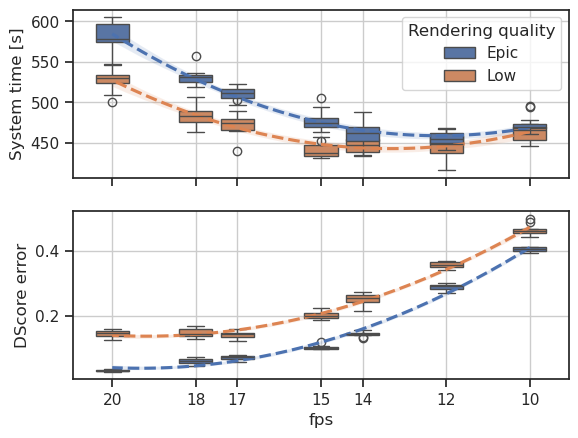

In [36]:
def new_boxplot(agg, ax, col='dscore_error'):

    data = agg.xs(False, level='upsteering')

    epicq = data.xs(True, level='highquality',
                    drop_level=False).reset_index()
    lowq = data.xs(False, level='highquality',
                   drop_level=False).reset_index()

    ax = sns.boxplot(lowq, x='fps', y=col, hue='highquality', ax=ax, native_scale=True, hue_order=[True, False]
                     )

    ax = sns.boxplot(epicq, x='fps', y=col,
                     hue='highquality', ax=ax,  native_scale=True, hue_order=[True, False])

    ax = sns.regplot(epicq, x='fps', y=col, ax=ax,
                     order=2, scatter=False, line_kws=dict(linestyle='dashed'),)
    ax = sns.regplot(lowq, x='fps', y=col, ax=ax,  order=2,
                     scatter=False, line_kws=dict(linestyle='dashed'),)


sns.set_theme(style="ticks", palette="deep")
f, axes = plt.subplots(nrows=2, sharex=True,)
axes[0].invert_xaxis()

axes[0].set_ylabel(f"System time [s]")
new_boxplot(agg, ax=axes[0], col='duration_system')
axes[0].grid()
axes[0].set_xticks(list(vals))
axes[0].set_ylabel(f"System time [s]")

new_boxplot(agg, ax=axes[1], col='dscore_error')
axes[1].get_legend().remove()
axes[1].grid()
axes[1].set_ylabel(f"DScore error")

handles, _ = axes[0].get_legend_handles_labels()

axes[0].legend(handles=handles, labels=["Epic", "Low"],
               title="Rendering quality")

f.savefig('boxplot_rq12.pdf', bbox_inches='tight')

### Plot upsteering


In [37]:
fidelity = (10, True)
data = agg.xs(fidelity)
data

dscore_error  duration_system
upsteering rep                               
False      0        0.403726       473.943607
           1        0.409581       462.006636
           2        0.391476       468.949601
           3        0.411916       471.472676
           4        0.399497       477.383813
           5        0.410068       468.876125
           6        0.401676       467.465099
           7        0.399037       495.182528
           8        0.409031       468.876868
           9        0.402806       460.705584
True       0        0.303344       422.152919
           1        0.301720       442.595601
           2        0.299109       442.196523
           3        0.303702       436.690009
           4        0.294695       447.811937
           5        0.278937       437.173263
           6        0.286591       442.664336
           7        0.295217       421.442814
           8        0.288335       440.169822
           9        0.288902       446.290934

<Axes: xlabel='upsteering', ylabel='dscore_error'>

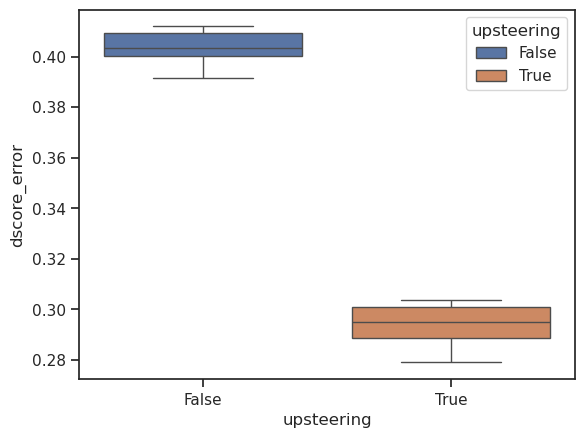

In [38]:
sns.boxplot(data=data, x='upsteering', y='dscore_error', hue='upsteering')

<Axes: xlabel='upsteering', ylabel='duration_system'>

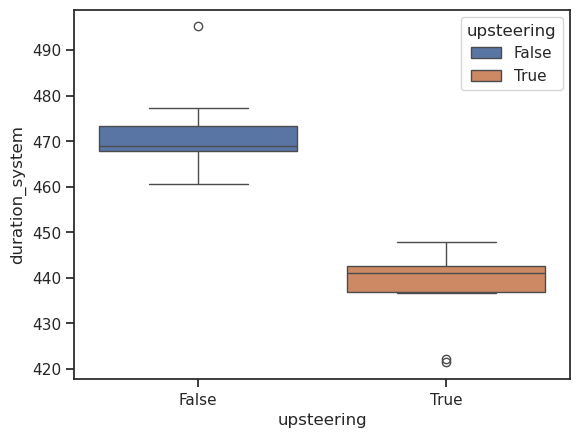

In [39]:
sns.boxplot(data=data, x='upsteering', y='duration_system', hue='upsteering')

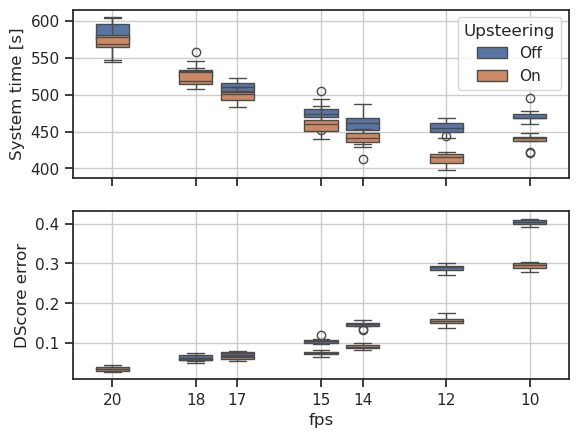

In [41]:
def new_boxplot(agg, ax, col='dscore_error'):

    data = agg.xs(True, level='highquality')

    # epicq = data.xs(True, level='highquality',
    #                 drop_level=False).reset_index()

    # lowq = data.xs(False, level='highquality',
    #                drop_level=False).reset_index()

    ax = sns.boxplot(data=data.xs(False, level='upsteering', drop_level=False), x='fps', y=col,
                     hue='upsteering', ax=ax,  native_scale=True, hue_order=[False, True])

    ax = sns.boxplot(data=data.xs(True, level='upsteering', drop_level=False), x='fps', y=col,
                     hue='upsteering', ax=ax,  native_scale=True, hue_order=[False, True])


sns.set_theme(style="ticks", palette="deep")
f, axes = plt.subplots(nrows=2, sharex=True,)
axes[0].invert_xaxis()

axes[0].set_ylabel(f"System time [s]")
new_boxplot(agg, ax=axes[0], col='duration_system')
axes[0].grid()
axes[0].set_xticks(list(vals))
axes[0].set_ylabel(f"System time [s]")

new_boxplot(agg, ax=axes[1], col='dscore_error')
axes[1].get_legend().remove()
axes[1].grid()
axes[1].set_ylabel(f"DScore error")

handles, _ = axes[0].get_legend_handles_labels()

axes[0].legend(handles=handles, labels=["Off", "On"],
               title="Upsteering")

f.savefig('upsteering.pdf', bbox_inches='tight')